In [1]:
import numpy as np
import rasterio as rio
from rasterio.plot import show
import os
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo import osr
from shapely.geometry import box
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import warnings
warnings.filterwarnings('ignore')

In [2]:
# User inputs
ip_dir = 'LC08_L1TP_140043_20180109_20180119_01_T1'
#extent = [86.1, 23.59, 86.5, 23.84]         #xmin, ymin, xmax, ymax. For manual AOI assignment
tir_band_num = int(10)
if tir_band_num!=10 and tir_band_num!=11:
    raise Exception("TIR band number in Landsat 8 are 10 and 11")

In [3]:
# To use a vector file to define AOI. This will override the extent defined in the previous cell.
import geopandas as gpd
shp = gpd.read_file('jcf_utm.shp')
extent = []
def vectorExtent(vector):
    vector_wgs = vector.to_crs(epsg = 4326)
    extent = []
    extent.append(vector_wgs.bounds['minx'].min())
    extent.append(vector_wgs.bounds['miny'].min())
    extent.append(vector_wgs.bounds['maxx'].max())
    extent.append(vector_wgs.bounds['maxy'].max())
    return extent

extent = vectorExtent(shp)
extent

[86.15616514820245, 23.64018650836813, 86.46829585938352, 23.822501809238567]

In [4]:
def project2WGS84 (ipRas, op_file_name): 
    # Checking the extension
    if op_file_name.endswith('.tif'):
        None
    else:
        op_file_name = op_file_name + '.tif'
        
    # Re-project to WGS 84
    op_crs = {'init': 'EPSG:4326'}
    transform, width, height = calculate_default_transform(
        ipRas.crs, op_crs, ipRas.width, ipRas.height, *ipRas.bounds)           # Transform parameters
    kwargs = ipRas.meta.copy()                                                 # Make a copy of Input metadata
    
    if ipRas.crs is None:
        raise Exception("Check data projections as well as integrity of proj package")
    # update the the copied parameters with required output output parameters 
    kwargs.update({
        'crs': op_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # writing output image
    opRas = rio.open(op_file_name, 'w', **kwargs)
    reproject(
        source= rio.band(ipRas, 1),
        destination= rio.band(opRas, 1),
        src_crs= ipRas.crs,
        dst_crs= op_crs,
        resampling=Resampling.nearest)
    opRas.close()
    return rio.open(op_file_name)

In [5]:
def raster_clip(ipRas, xmin, ymin, xmax, ymax, op_file_name):
    # Checking extension of the output file
    if op_file_name.endswith('.tif'):
        None
    else:
        op_file_name = op_file_name + '.tif'
    
    boundary = box(xmin, ymin, xmax, ymax)
    coords = [{'type': 'Polygon',
               'coordinates': [[[xmin,ymin],[xmin,ymax],[xmax,ymax],[xmax,ymin],[xmin,ymin]]]}]
    out_img, out_transform = mask(dataset=ipRas, shapes=coords, crop=True)
    out_meta = ipRas.meta.copy()
    epsg_num = int(ipRas.crs.data['init'].split(':')[1])

    out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],"width": out_img.shape[2],
                 "transform": out_transform, "crs": ipRas.crs}
               )
    #"crs":pycrs.parse.from_epsg_code(epsg_num).to_proj4()
    
    with rio.open(op_file_name, "w", **out_meta) as dest:
        dest.write(out_img)
    return rio.open(op_file_name)

In [6]:
def dn2temp(dir):
    i = j = 0
    files=os.listdir(dir)
    for file in files:
        
        # Getting the meta data
        if file.endswith("_MTL.txt"):
            i = i+1
            meta=[]
            meta_file = open(os.path.join(ip_dir, file),"r")
            meta = meta_file.readlines()
            meta_file.close()
        
        # Loading TIR data
        if file.endswith("_B" + str(tir_band_num) + ".TIF"):
            j = j+1
            tir_file = rio.open(os.path.join(ip_dir, file))
    
    # Checking the integrity of input files
    if i>1 or j>1:
        raise Exception("Multiple input files within the input directory")
    if i==0 or j==0:
        raise Exception("Unable to find input files")    
    
    # Projecting to WGS and clipping of TIR
    tir_wgs = project2WGS84(tir_file, "tir_wgs84")
    tir_wgs_cliped = raster_clip(tir_wgs, extent[0], extent[1], extent[2], extent[3], "tir_wgs_clip") 
    # Converting to an array for manipulations        
    tir = np.empty(shape=(tir_wgs_cliped.shape))
    tir = tir_wgs_cliped.read(1).astype(float)
    
    # Getting constants from meta data
    for line in meta:
        if 'RADIANCE_MULT_BAND_'+ str(tir_band_num) in line:
            rad_mult = float(line.split('=')[1])
        if 'RADIANCE_ADD_BAND_'+ str(tir_band_num) in line:
            rad_add = float(line.split('=')[1])
        if 'K1_CONSTANT_BAND_' + str(tir_band_num) in line:
            k1 = float(line.split('=')[1])
        if 'K2_CONSTANT_BAND_' + str(tir_band_num) in line:
            k2 = float(line.split('=')[1])
    
    # conversion to radiance and then to at-sensor brightness temp
    tir_rad = rad_add + (rad_mult * tir)
    denomin = np.log((k1/tir_rad)+1)
    temperature = (k2/denomin)-273.15  #to get result in celcius

    return temperature

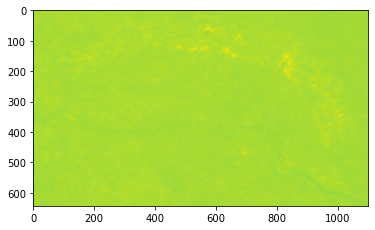

<AxesSubplot:>

In [7]:
temperature = dn2temp(ip_dir)
show(temperature)

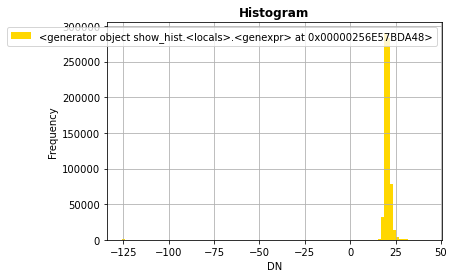

In [8]:
rio.plot.show_hist(temperature, bins=100)

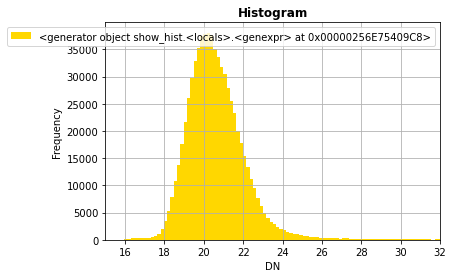

In [9]:
fig, ax = plt.subplots()
ax.set_xlim(15,32)   #To avoid faulty pixels
rio.plot.show_hist(temperature, bins=1000, ax=ax)

In [10]:
threshold = float(input("Enter the threshold value: "))

Enter the threshold value: 24


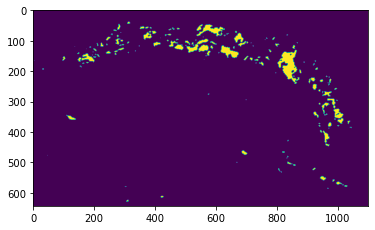

<AxesSubplot:>

In [11]:
temperature[np.where(temperature<threshold)] = 0        # can be np.nan 
temperature[np.where(temperature>=threshold)] = 1      #comment this line to get original temp values for the coal fire pixels
show(temperature)

In [12]:
def ReferencedGeocode(refRas, npArray,op_file_name):
    # Checking extension of the output file
    if op_file_name.endswith('.tif'):
        None
    else:
        op_file_name = op_file_name + '.tif'
        
    # Getting info for geocoding
    xmin, ymin, xmax, ymax = refRas.bounds
    nrows,ncols = np.shape(npArray)
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    geotransform = xmin, xres, 0, ymax, 0, -yres 
    epsg_num = int(refRas.crs.data['init'].split(':')[1])
    
    # Applying the geocoding
    output_raster = gdal.GetDriverByName('GTiff').Create(op_file_name, ncols, nrows, 1, gdal.GDT_Float32)  
    output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
    srs = osr.SpatialReference()                 # Establish its coordinate encoding
    srs.ImportFromEPSG(epsg_num)
    output_raster.SetProjection(srs.ExportToWkt()) 
    output_raster.GetRasterBand(1).WriteArray(npArray)
    output_raster.FlushCache()
    
    return rio.open(op_file_name)

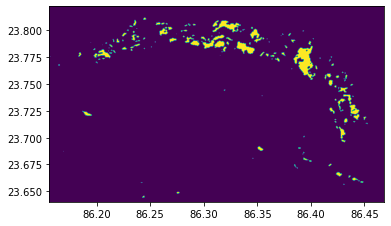

<AxesSubplot:>

In [13]:
ref_ras = rio.open('tir_wgs_clip.tif')
coal_fire = ReferencedGeocode(ref_ras, temperature, "jcf")
show(coal_fire)

<b>Refernces</b><br>
Raster clip: https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html<br>
Projection: https://hatarilabs.com/ih-en/how-to-reproject-single-and-multiple-rasters-with-python-and-rasterio-tutorial